In [1]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=aa6483e0cdfcb47b830baa1fd21d73ec4e938e63c78c82d97654634f5c50641f
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


**Les importations**

In [2]:
from deepface import DeepFace
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import Image
import os


25-04-03 10:40:49 - Directory /root/.deepface has been created
25-04-03 10:40:49 - Directory /root/.deepface/weights has been created


**fonction pour prendre un photo avec WebCam**

In [3]:
def capture_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function capturePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('capturePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


**Charger ou prendre  un photo  de reference**

<IPython.core.display.Javascript object>

Captured a new photo and saved as user photo: votre_photo.jpg


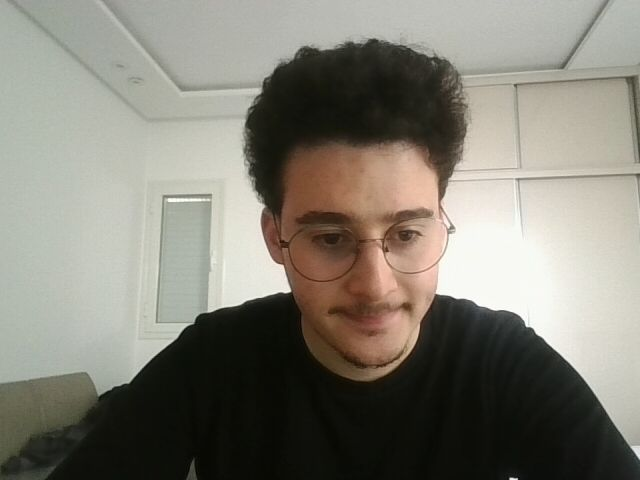

In [5]:
user_image_path = 'votre_photo.jpg'

if os.path.exists(user_image_path):
    user_image = cv2.imread(user_image_path)
    print(f'Loaded user photo: {user_image_path}')
else:
    try:
        captured_image = capture_photo('votre_photo.jpg')
        print(f'Captured a new photo and saved as user photo: {user_image_path}')
        display(Image(captured_image))
    except Exception as error:
        print(f'Error: {str(error)}')

reference_image_path = 'votre_photo.jpg'
reference_image = cv2.imread(reference_image_path)


**prendre une image pour tester**

<IPython.core.display.Javascript object>

Saved the photo as: photo.jpg


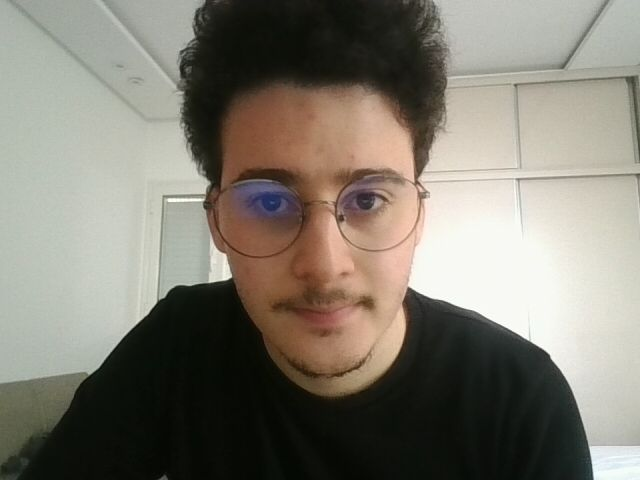

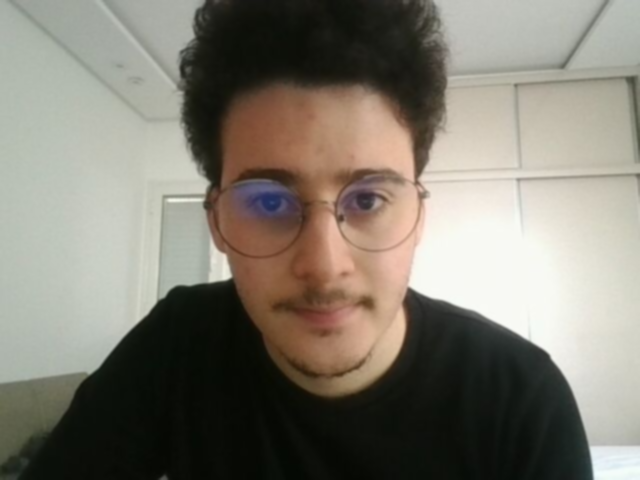

In [6]:
try:
    new_photo = capture_photo()
    print(f'Saved the photo as: {new_photo}')
    display(Image(new_photo))
except Exception as error:
    print(str(error))

test_image_path = 'photo.jpg'
test_image = cv2.imread(test_image_path)

# Appliquer un filtre gaussien à l'image de test pour réduire le bruit et lisser les détails !(phase pré-traitement)
filtred_test_image = cv2.GaussianBlur(test_image, (5, 5), 0)

test_image = filtred_test_image
cv2_imshow(filtred_test_image)



Comparer le deux visages


In [8]:
image_path = 'photo.jpg'
try:
  test_image = cv2.imread(image_path)

  res =DeepFace.verify(reference_image,test_image)

  if res["verified"] :
    print("---------------------------------------  C' est  vous -------------------------\n"
        + "****************************************Acces autoirse ******************************\n")
  else :
    print("--------------------------------------- non non ce n'est pas vous -------------------------\n"
        + "****************************************Acces  non autoirse ******************************\n")
except Exception as err:
  print("-------------------------------------- Aucun visage détéctéé ---------------------------")


---------------------------------------  C' est  vous -------------------------
****************************************Acces autoirse ******************************



**Detecter les visages et les encadrer**

In [11]:
from google.colab import files
uploaded = files.upload()

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


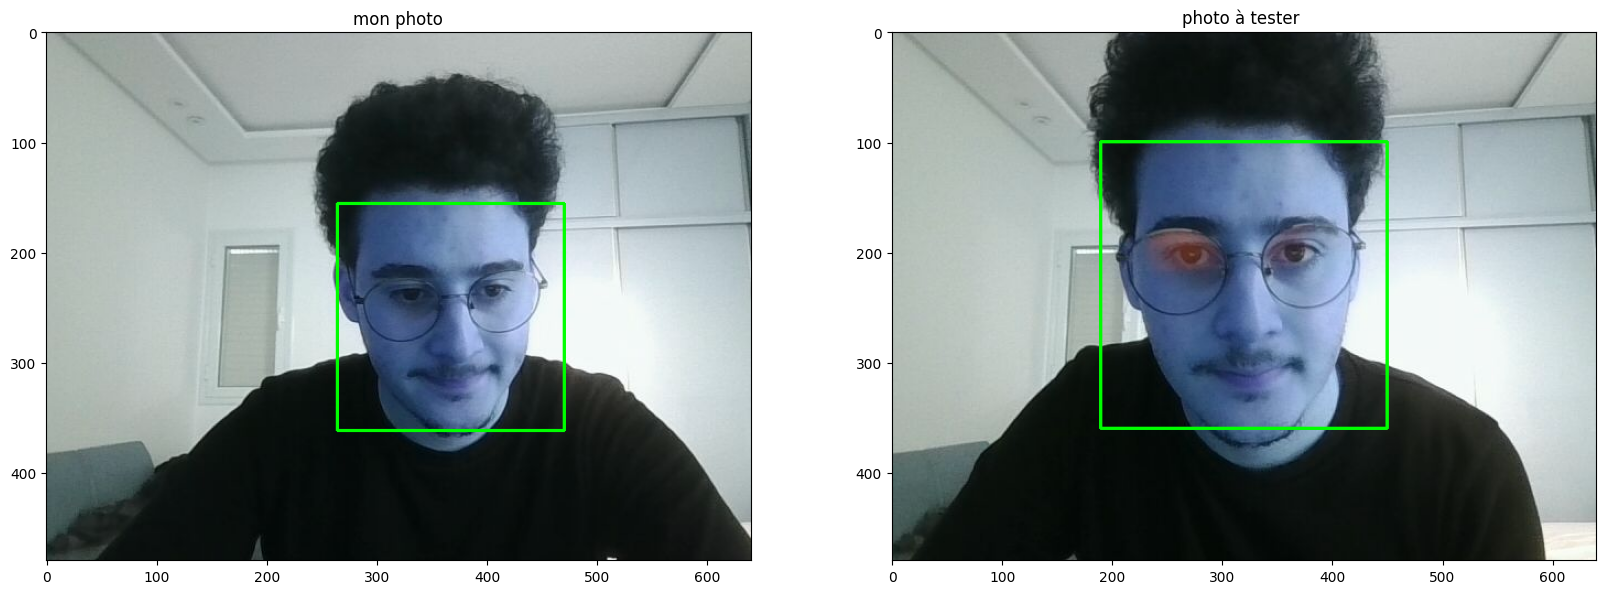

In [12]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
gray_test = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

faces_reference = face_cascade.detectMultiScale(gray_reference, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))
faces_test = face_cascade.detectMultiScale(gray_test, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

if len(faces_reference) > 0 and len(faces_test) > 0:
    (x_ref, y_ref, w_ref, h_ref) = faces_reference[0]
    (x_test, y_test, w_test, h_test) = faces_test[0]

for (x, y, w, h) in faces_reference:
    cv2.rectangle(reference_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

for (x, y, w, h) in faces_test:
    cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, axes = plt.subplots(1, 2, figsize=(20, 100))
axes[0].imshow(reference_image)
axes[0].set_title("mon photo")
axes[1].set_title("photo à tester ")
axes[1].imshow(test_image)